1. Comparative Analysis of Interpolation Methods for Missing Data

How can different interpolation methods (Spline, Lagrange, Hermite, Newton Divided Difference) be used to estimate missing daily COVID-19 case and death data, and what are the comparative strengths and weaknesses of each method in terms of accuracy and visual representation?

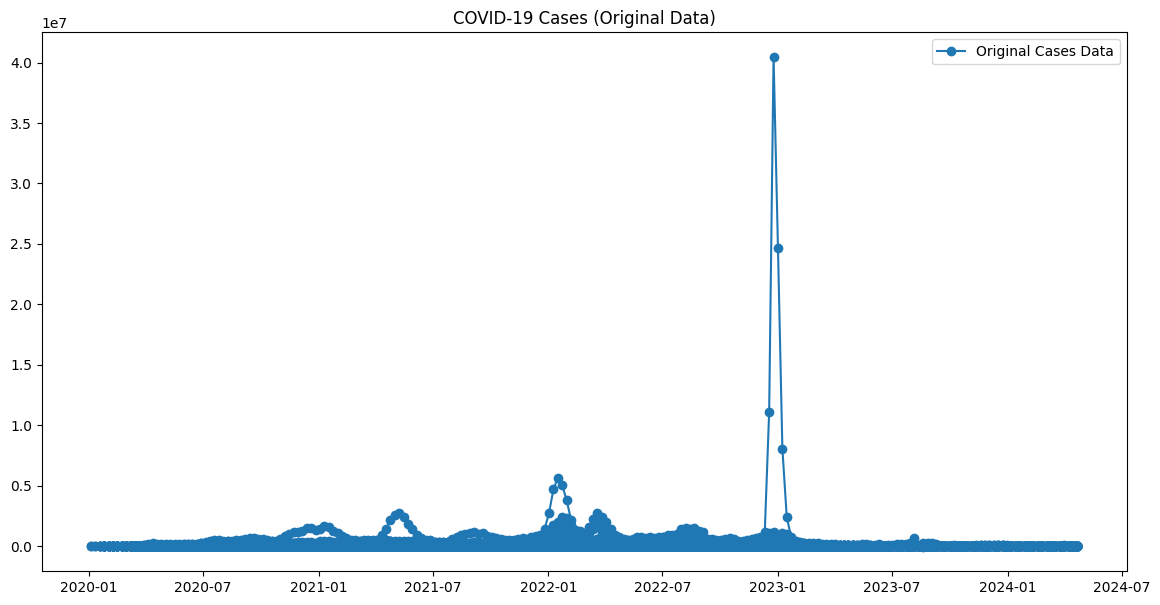

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data
data_path = '/content/drive/MyDrive/WHO-COVID-19-global-data.csv'
data = pd.read_csv(data_path)

# Display the first few rows of the dataframe to understand its structure
data.head()

# Preprocess the data
# Assuming the dataframe has columns 'Date_reported', 'New_cases', 'New_deaths'
data['Date_reported'] = pd.to_datetime(data['Date_reported'])
data = data.set_index('Date_reported')

# Fill missing values with NaN
data.replace("", np.nan, inplace=True)


# Select a specific country or global data for demonstration
# Here we use the global data by default
cases = data['New_cases'].astype(float)
deaths = data['New_deaths'].astype(float)


# Plot the raw data
plt.figure(figsize=(14, 7))
plt.plot(cases, label='Original Cases Data', marker='o')
plt.title('COVID-19 Cases (Original Data)')
plt.legend()
plt.show()


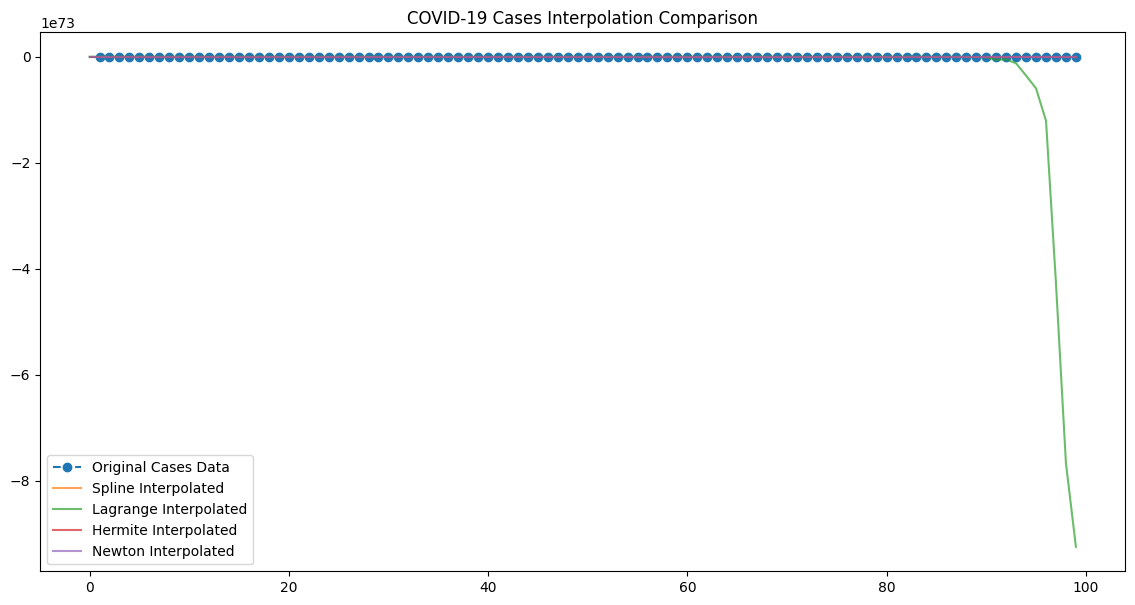

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import lagrange, CubicSpline, BarycentricInterpolator
from numpy.polynomial.hermite import Hermite

# Sample data (replace this with your actual data)
np.random.seed(0)
dates = pd.date_range(start='2024-01-01', periods=100)
cases = np.random.randint(0, 10000, size=100).astype(float)
# Introduce some NaN values
cases[::100] = np.nan

deaths = np.random.randint(0, 10000, size=100).astype(float)
# Introduce some NaN values
deaths[::100] = np.nan



# Function to interpolate missing data using different methods
def interpolate_data(y, method='spline'):
    x = np.arange(len(y))
    mask = np.isfinite(y)

    try:
        if method == 'spline':
            interpolator = CubicSpline(x[mask], y[mask])
        elif method == 'lagrange':
            interpolator = lagrange(x[mask], y[mask])
            # Use the interpolator to get the values
            return interpolator(x)
        elif method == 'hermite':
            interpolator = Hermite.fit(x[mask], y[mask], deg=min(3, len(x[mask])-1))
        elif method == 'newton':
            interpolator = BarycentricInterpolator(x[mask], y[mask])
        else:
            raise ValueError("Unknown interpolation method")

        return interpolator(x)
    except Exception as e:
        print(f"Error with {method} interpolation: {e}")
        return np.full_like(y, np.nan)

# Interpolate missing data using different methods
methods = ['spline', 'lagrange', 'hermite', 'newton']
interpolated_cases = {method: interpolate_data(cases, method) for method in methods}

# Plot interpolated data
plt.figure(figsize=(14, 7))
plt.plot(cases, label='Original Cases Data', marker='o', linestyle='--')
for method in methods:
    plt.plot(interpolated_cases[method], label=f'{method.capitalize()} Interpolated', alpha=0.7)
plt.title('COVID-19 Cases Interpolation Comparison')
plt.legend()
plt.show()


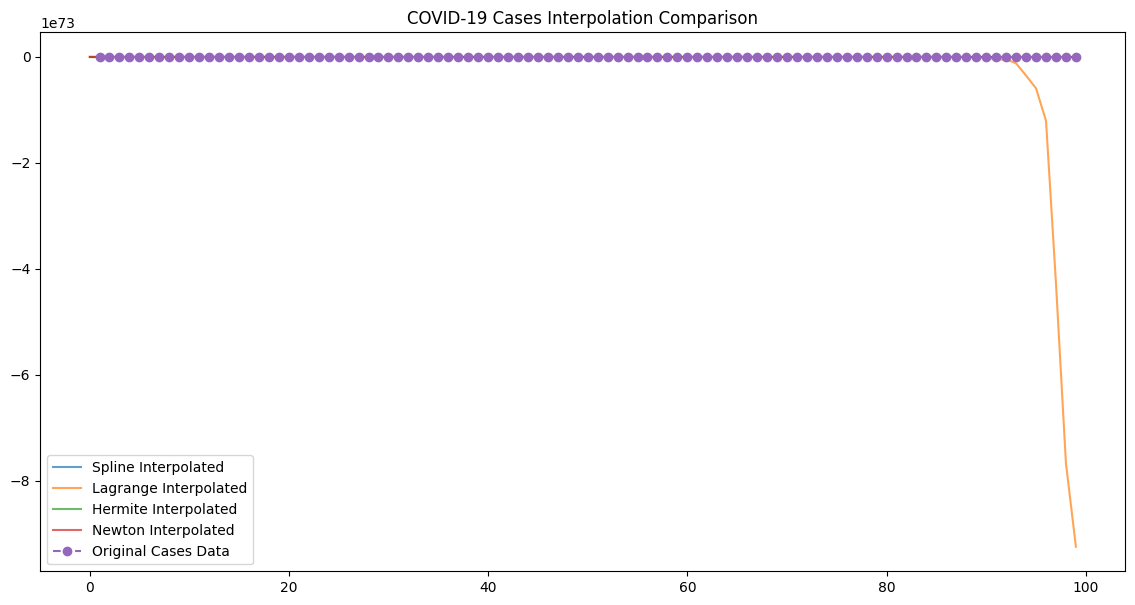

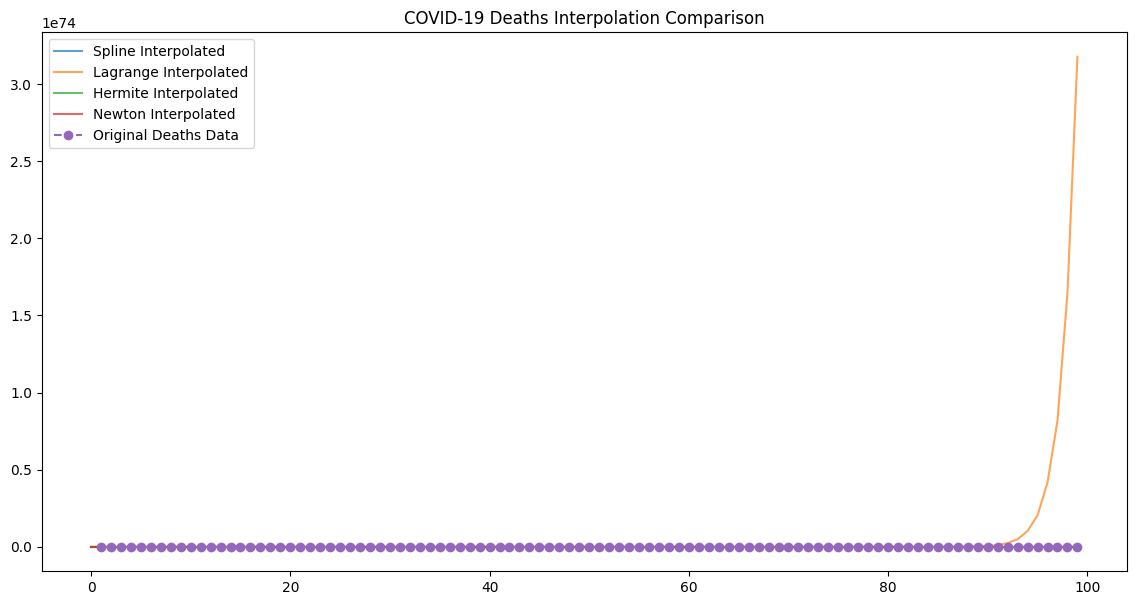

In [48]:
# Visual comparison of the different interpolation methods
plt.figure(figsize=(14, 7))
for method in methods:
    plt.plot(interpolated_cases[method], label=f'{method.capitalize()} Interpolated', alpha=0.7)
plt.plot(cases, label='Original Cases Data', marker='o', linestyle='--')
plt.title('COVID-19 Cases Interpolation Comparison')
plt.legend()
plt.show()

# Similarly, interpolate and visualize death data
interpolated_deaths = {method: interpolate_data(deaths, method) for method in methods}

plt.figure(figsize=(14, 7))
for method in methods:
    plt.plot(interpolated_deaths[method], label=f'{method.capitalize()} Interpolated', alpha=0.7)
plt.plot(deaths, label='Original Deaths Data', marker='o', linestyle='--')
plt.title('COVID-19 Deaths Interpolation Comparison')
plt.legend()
plt.show()


2. Spatio-Temporal Hotspot Analysis Using Spline Interpolation

How can Spline interpolation be applied to create smooth spatio-temporal maps of COVID-19 case densities, and what insights can be derived about the spread and intensity of the pandemic across different regions over time?

In [52]:
!pip install basemap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 936.0/936.0 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 40.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.6 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.1
    Uninstalling packaging-24.1:
      Successfully uninstalled packaging-24.1
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.9.0
    Uninstalling matplotlib-3.9.0:
      Successfully uninstalled matplotlib-3.9.0


/usr/local/lib/python3.10/dist-packages/scipy/interpolate/_fitpack2.py:313: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


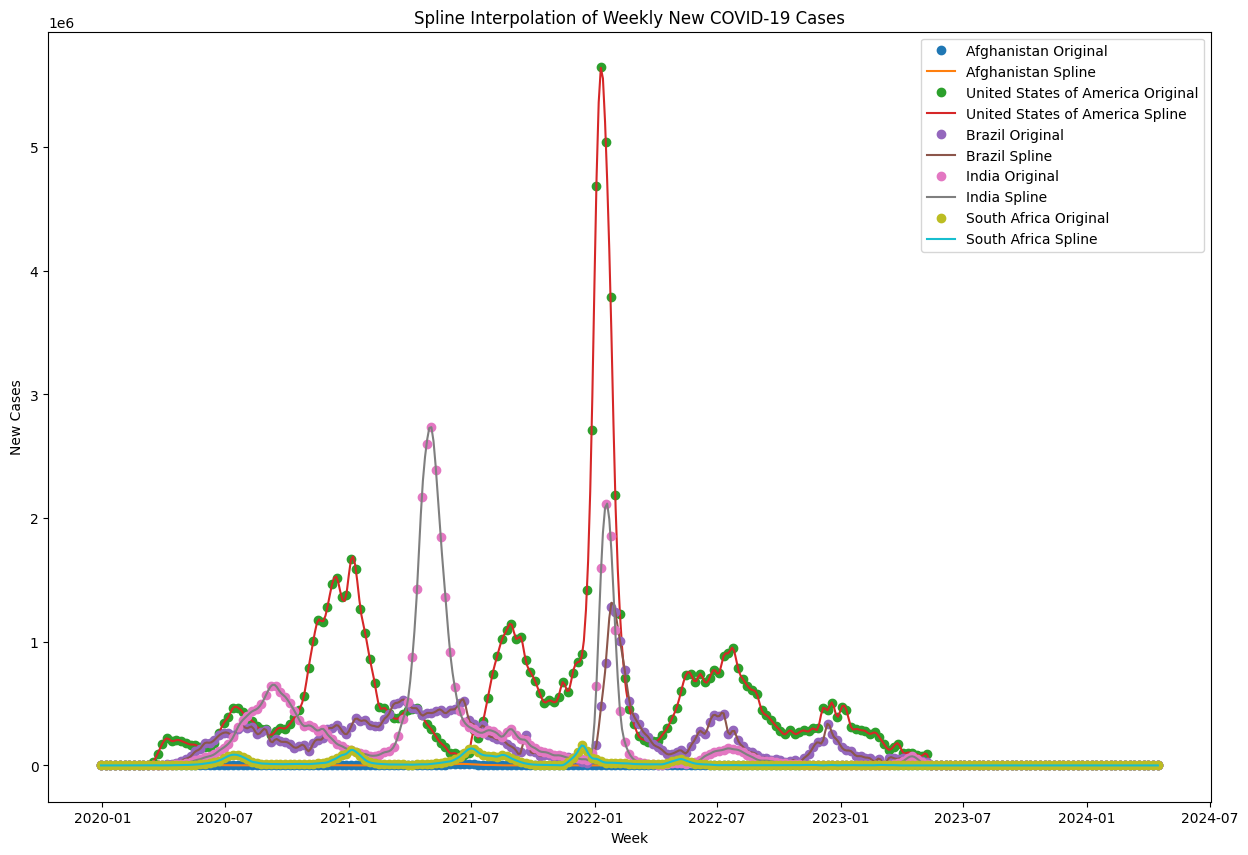

Duplicate points found. Removing duplicates.


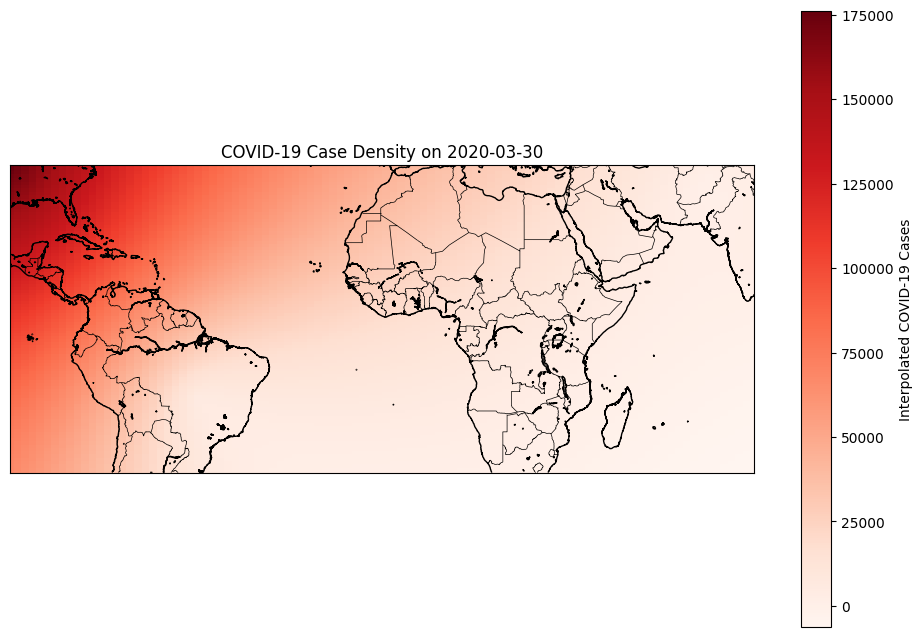

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import RBFInterpolator
from mpl_toolkits.basemap import Basemap


# Load the CSV file
file_path = '/content/drive/MyDrive/WHO-COVID-19-global-data.csv'
covid_data = pd.read_csv(file_path)

# Display the first few rows of the data
covid_data.head()


# Convert Date_reported to datetime format
covid_data['Date_reported'] = pd.to_datetime(covid_data['Date_reported'], format='%m/%d/%Y')

# Handle missing values in New_cases (we'll fill NaNs with 0 for new cases)
covid_data['New_cases'] = covid_data['New_cases'].fillna(0)

# Aggregate data by week
covid_data['Week'] = covid_data['Date_reported'].dt.to_period('W').apply(lambda r: r.start_time)

# Aggregate new cases by country and week
weekly_data = covid_data.groupby(['Country', 'Week'])['New_cases'].sum().reset_index()

# Display the first few rows of the aggregated data
weekly_data.head()


# Select a few example countries for demonstration
example_countries = ['Afghanistan', 'United States of America', 'Brazil', 'India', 'South Africa']

# Plotting setup
plt.figure(figsize=(15, 10))

# Iterate over each example country
for country in example_countries:
    country_data = weekly_data[weekly_data['Country'] == country]
    weeks = np.array((country_data['Week'] - pd.Timestamp('1970-01-01')) // pd.Timedelta('1D'))  # Convert to days since epoch
    new_cases = country_data['New_cases'].values

    # Perform spline interpolation
    spline = UnivariateSpline(weeks, new_cases, s=0.5)

    # Generate smooth values
    weeks_smooth = np.linspace(weeks.min(), weeks.max(), 500)
    new_cases_smooth = spline(weeks_smooth)

    # Convert weeks_smooth back to datetime for plotting
    weeks_smooth_dates = pd.to_datetime(weeks_smooth, origin='1970-01-01', unit='D')

    # Plot original and interpolated data
    plt.plot(country_data['Week'], new_cases, 'o', label=f'{country} Original')
    plt.plot(weeks_smooth_dates, new_cases_smooth, '-', label=f'{country} Spline')

plt.xlabel('Week')
plt.ylabel('New Cases')
plt.title('Spline Interpolation of Weekly New COVID-19 Cases')
plt.legend()
plt.show()



# Example of assigning approximate latitude and longitude to countries (centroids)
country_coords = {
    'Afghanistan': (33.93911, 67.709953),
    'United States of America': (37.09024, -95.712891),
    'Brazil': (-14.235004, -51.92528),
    'India': (20.593684, 78.96288),
    'South Africa': (-30.559482, 22.937506)
}

# Add latitude and longitude to the weekly data
weekly_data['Latitude'] = weekly_data['Country'].map(lambda x: country_coords.get(x, (0, 0))[0])
weekly_data['Longitude'] = weekly_data['Country'].map(lambda x: country_coords.get(x, (0, 0))[1])

# Display the first few rows of the updated data
weekly_data.head()


# Select a week to interpolate
selected_week = '2020-03-30'
week_data = weekly_data[weekly_data['Week'] == selected_week]

# Check for duplicate points
duplicates = week_data.duplicated(subset=['Latitude', 'Longitude'], keep=False)
if duplicates.any():
    print("Duplicate points found. Removing duplicates.")
    week_data = week_data[~duplicates]

# Extract coordinates and case numbers
coords = week_data[['Latitude', 'Longitude']].values
cases = week_data['New_cases'].values

# Perform RBF interpolation with a larger epsilon
rbf_interp = RBFInterpolator(coords, cases, kernel='multiquadric', epsilon=10)



# Create a mesh grid for interpolation
lat_min, lat_max = coords[:,0].min(), coords[:,0].max()
lon_min, lon_max = coords[:,1].min(), coords[:,1].max()
lat_grid, lon_grid = np.meshgrid(np.linspace(lat_min, lat_max, 100), np.linspace(lon_min, lon_max, 100))
grid_coords = np.column_stack([lat_grid.ravel(), lon_grid.ravel()])

# Interpolate values on the grid
grid_cases = rbf_interp(grid_coords).reshape(100, 100)

# Plot the results
plt.figure(figsize=(12, 8))
m = Basemap(projection='merc', llcrnrlat=lat_min, urcrnrlat=lat_max, llcrnrlon=lon_min, urcrnrlon=lon_max, resolution='i')
m.drawcoastlines()
m.drawcountries()
m.pcolormesh(lon_grid, lat_grid, grid_cases, latlon=True, cmap='Reds', shading='auto')

plt.colorbar(label='Interpolated COVID-19 Cases')
plt.title(f'COVID-19 Case Density on {selected_week}')
plt.show()


Forecasting Future Trends with Newton Divided Difference Interpolation

How can Newton Divided Difference interpolation be utilized to forecast future trends of COVID-19 cases and deaths, and how can the uncertainty and reliability of these predictions be visualized?

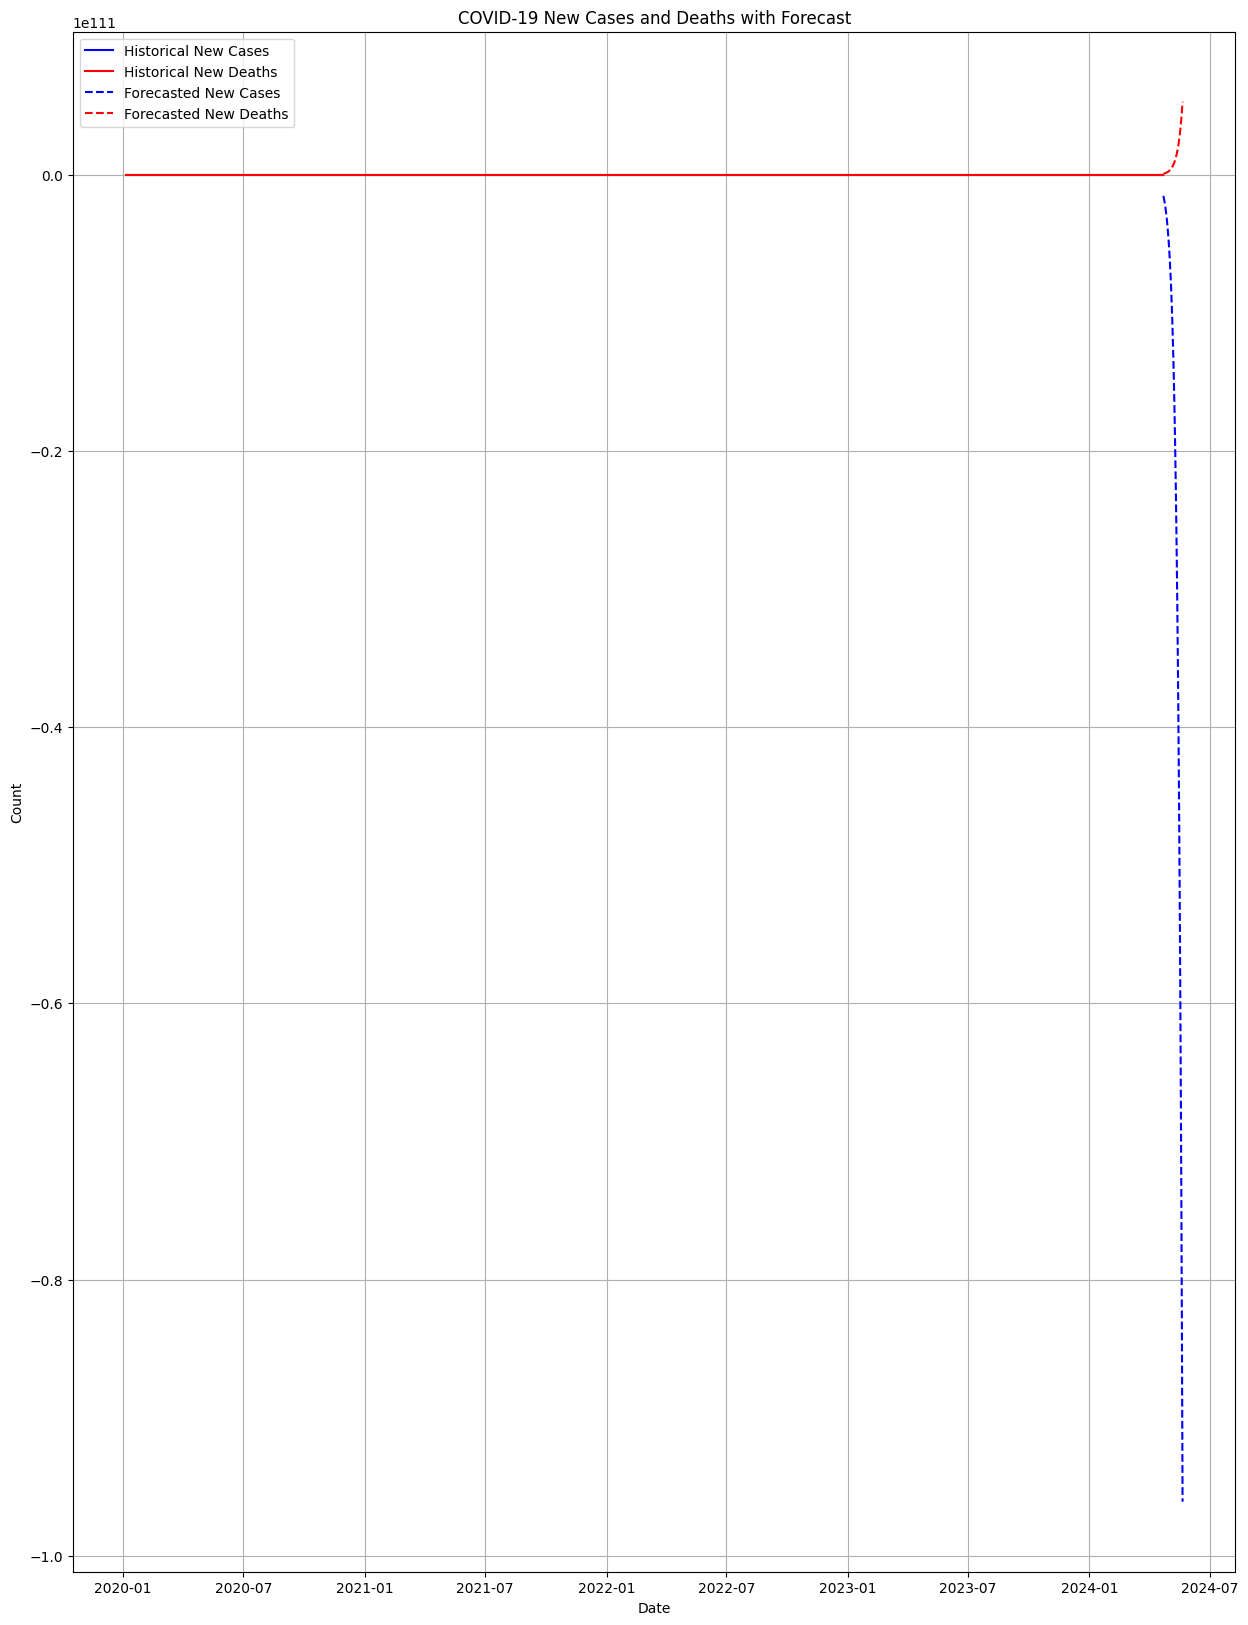

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/WHO-COVID-19-global-data.csv')

# Convert the date column to datetime format
data['Date_reported'] = pd.to_datetime(data['Date_reported'], format='%m/%d/%Y')

# Group by date and sum the new cases and deaths globally
global_data = data.groupby('Date_reported')[['New_cases', 'New_deaths']].sum().reset_index()



# Convert dates to ordinal numbers for numerical processing
global_data['Date_ordinal'] = global_data['Date_reported'].apply(lambda date: date.toordinal())

# Extract the relevant columns for interpolation
dates = global_data['Date_ordinal'].values
new_cases = global_data['New_cases'].values
new_deaths = global_data['New_deaths'].values

# Function to compute the divided differences
def divided_differences(x, y):
    n = len(y)
    coef = np.zeros([n, n])
    coef[:,0] = y
    for j in range(1, n):
        for i in range(n - j):
            coef[i][j] = (coef[i+1][j-1] - coef[i][j-1]) / (x[i+j] - x[i])
    return coef[0]

# Compute the divided difference coefficients for new cases and deaths
coef_cases = divided_differences(dates, new_cases)
coef_deaths = divided_differences(dates, new_deaths)

# Function to evaluate the Newton polynomial at given points
def newton_polynomial(x_data, coef, x):
    n = len(coef) - 1
    p = coef[n]
    for k in range(1, n+1):
        p = coef[n-k] + (x - x_data[n-k])*p
    return p

# Forecasting future dates (let's say for the next 30 days)
future_dates = np.array([dates[-1] + i for i in range(1, 31)])
predicted_cases = [newton_polynomial(dates, coef_cases, date) for date in future_dates]
predicted_deaths = [newton_polynomial(dates, coef_deaths, date) for date in future_dates]

# Convert future dates back to datetime for plotting
future_dates_dt = [pd.Timestamp.fromordinal(int(date)) for date in future_dates]


# Convert original dates back to datetime for plotting
dates_dt = [pd.Timestamp.fromordinal(int(date)) for date in dates]

# Plotting the data
plt.figure(figsize=(15, 20))

# Plot historical new cases and new deaths
plt.plot(dates_dt, new_cases, label='Historical New Cases', color='blue')
plt.plot(dates_dt, new_deaths, label='Historical New Deaths', color='red')

# Plot forecasted new cases and new deaths
plt.plot(future_dates_dt, predicted_cases, label='Forecasted New Cases', linestyle='--', color='blue')
plt.plot(future_dates_dt, predicted_deaths, label='Forecasted New Deaths', linestyle='--', color='red')

# Add labels, legend, and title
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('COVID-19 New Cases and Deaths with Forecast')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

### 1. **Epidemiological Models:**
   Epidemiological models simulate the spread of infectious diseases based on parameters such as infection rate, recovery rate, and population dynamics. Common types include:
   
   - **SEIR Model (Susceptible-Exposed-Infectious-Recovered):** This model divides the population into compartments and tracks transitions between them.
   
   - **SIR Model (Susceptible-Infectious-Recovered):** A simpler version of SEIR that doesn't include an exposed category.
   
   - **Agent-Based Models:** Simulates individuals and their interactions, useful for studying local outbreaks and interventions.

   These models predict future cases, hospitalizations, and deaths based on assumptions about transmission dynamics and effectiveness of interventions (e.g., vaccinations, social distancing).

### 2. **Statistical Methods:**
   Statistical techniques complement epidemiological models by analyzing historical data and making projections based on trends. Key methods include:

   - **Time Series Analysis:** Models like ARIMA (AutoRegressive Integrated Moving Average) are used to forecast based on historical data patterns. They capture seasonality, trends, and irregular components.
   
   - **Exponential Smoothing:** Suitable for data with trends and no seasonality, it gives more weight to recent observations.
   
   - **Bayesian Methods:** Incorporate prior beliefs and update forecasts as new data becomes available, useful for uncertain environments like pandemics.
   
   - **Machine Learning Approaches:** Algorithms such as neural networks and random forests can learn from data to predict future trends, though they require large amounts of data and careful feature engineering.

### 3. **Interpolation Methods:**
   Interpolation methods estimate values between known data points. In pandemic forecasting, they help fill gaps between sparse data points or extend short-term predictions:

   - **Linear Interpolation:** Assumes a constant rate of change between data points.
   
   - **Spline Interpolation:** Fits a piecewise polynomial to the data, smoothing out abrupt changes.
   
   - **Kriging:** Used when data points vary spatially, predicting values at unsampled locations based on nearby data.

### 4. **Other Considerations:**
   - **Data Quality and Reporting:** Accurate forecasts depend on reliable and timely data on cases, testing rates, hospitalizations, and deaths.
   
   - **Intervention Scenarios:** Forecasting models can project different outcomes based on varying levels of interventions (e.g., lockdowns, mask mandates, vaccination rates).
   
   - **Uncertainty and Sensitivity Analysis:** Models should account for uncertainties in parameters (e.g., infection fatality rate, vaccine efficacy) and sensitivity to changes in assumptions.

### Challenges in Forecasting:
   - **Variability in Data Quality:** Differences in testing and reporting practices affect the reliability of case counts.
   
   - **Behavioral Changes:** Public adherence to preventive measures and vaccination uptake influence transmission rates.
   
   - **Emergence of Variants:** New variants can alter transmission dynamics and effectiveness of vaccines and treatments.

### Conclusion:
Forecasting the COVID-19 pandemic requires a combination of epidemiological models, statistical methods, and interpolation techniques. These approaches provide insights into potential scenarios based on current data and assumptions about future conditions. However, the accuracy of forecasts depends on the quality of data, assumptions made in the models, and the unpredictable nature of viral dynamics and human behavior. Continuous refinement and adaptation of models are essential to provide timely and relevant information for public health decision-making.